# Weight Decay

*Weight decay* (commonly called $\ell_2$ regularization),
might be the most widely-used technique
for regularizing parametric machine learning models

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

Generate some data as before
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2)$$

In [2]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b

    def train_dataloader(self):
        data = (self.X[:self.num_train], self.y[:self.num_train])
        return d2l.tensorloader(data, self.batch_size, shuffle=True)

    def val_dataloader(self):
        data = (self.X[self.num_train:], self.y[self.num_train:])
        return d2l.tensorloader(data, self.batch_size, shuffle=False)

Defining $\ell_2$ Norm Penalty

In [6]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.lambd * l2_penalty(self.w)

@d2l.add_to_class(d2l.LinearRegressionScratch)  
def validation_step(self, batch):
    X, y = batch
    l = self.loss(self(X), y)
    self.board.draw(self.trainer.epoch+1, l, 'val_loss',
                    every_n=self.trainer.num_val_batches)

data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.003)
    model.board.ylim = [1e-3, 1]
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

Training without Regularization

L2 norm of w: 87.02771759033203


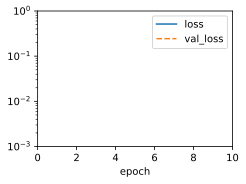

In [7]:
train_scratch(0)

Using Weight Decay

L2 norm of w: 46.36259841918945


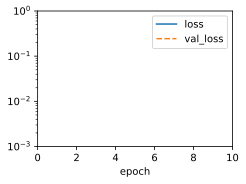

In [8]:
train_scratch(3)

Concise Implementation

In [9]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, num_inputs, wd, lr):
        super().__init__(num_inputs, lr)
        self.save_hyperparameters()

    def configure_optimizers(self):
        return torch.optim.SGD([
            {"params":self.net.weight,'weight_decay': self.wd},
            {"params":self.net.bias}], lr=self.lr)

The plots look identical to those when
we implemented weight decay from scratch

L2 norm of w: 0.0811074823141098


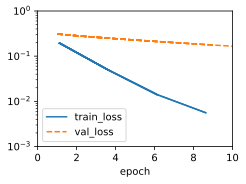

In [10]:
model = WeightDecay(num_inputs=200, wd=3, lr=0.003)

model.board.ylim = [1e-3, 1]
trainer.fit(model, data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))